In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, A1TDISens,E1TDISens, T1TDISens, AET1SensitivityMatrix

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [2]:
Tobs = YRSID_SI
dt = 5.
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))

sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, )

In [3]:
#sim.generate_noise(seed=42, )

In [4]:
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))

f_ref   = np.array([0.0, 0.0])  # let phenom codes set fRef -> fmax = max(f^2A(f))
phi_ref = np.array([0.0, 1.0])
m1      = np.array([1e6, 8e5])
m2      = np.array([5e5, 2e5])
a1      = np.array([0.2, 0.8])
a2      = np.array([0.4, 0.7])
dist    = np.array([10e3, 10e3])  * PC_SI * 1e6 # 3e3 in Mpc
inc     = np.array([np.pi/3, np.pi/4])
beta    = np.array([np.pi/4., np.pi/5])
lam     = np.array([np.pi/5., np.pi/6])
psi     = np.array([np.pi/6., np.pi/7])
t_ref   = np.array([0.5, 0.8]) * YRSID_SI  # in the SSB reference frame

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(direct=False, fill=True, squeeze=False, length=1024)


wave = sim.generate_waveform(parameters, modes, waveform_kwargs)
wave.shape

(2, 3, 3155815)

In [18]:
parameters.ndim

2

In [10]:
wave_t = np.fft.irfft(wave, axis=-1)
total_waveform_t = wave_t.sum(axis=0)

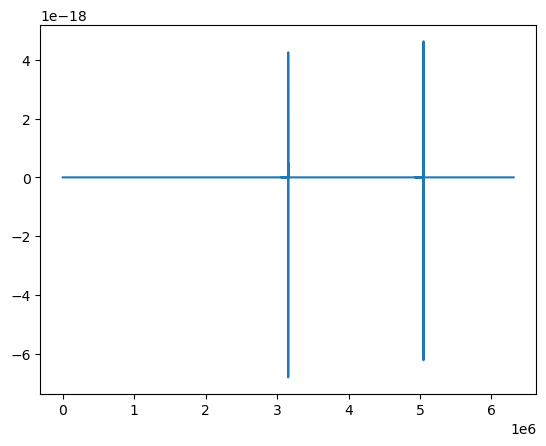

In [11]:
plt.plot(total_waveform_t[0])

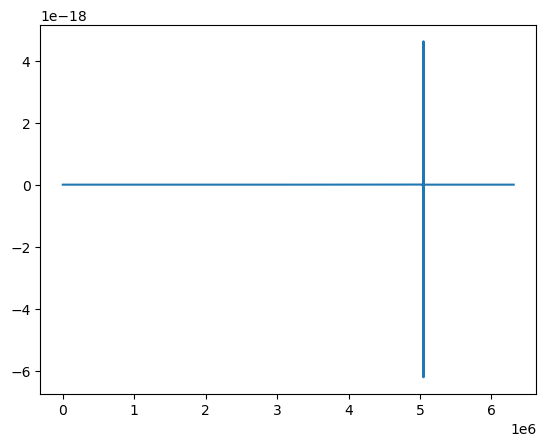

In [9]:
plt.plot(wave_t[1, 0, :], label='m1=1e6, m2=5e5')

Text(0, 0.5, '$\\tilde{h}(f)$ (Hz$^{-1/2}$)')

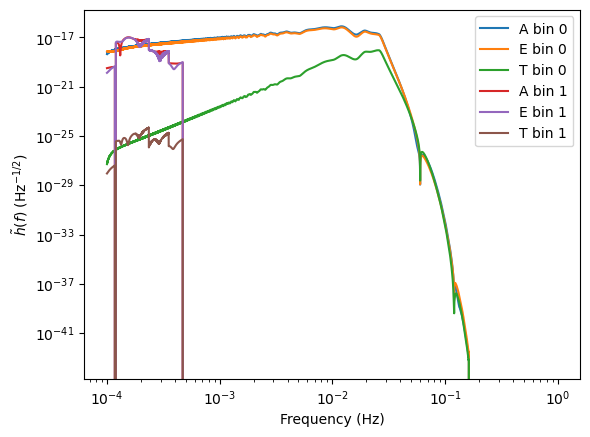

In [5]:

# frequencies to interpolate to
freq_new = np.logspace(-4, 0, 10000)
modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]

waves = wave_gen( *parameters,
                  freqs=freq_new,
                  modes=modes, direct=False, fill=True, squeeze=False, length=1024)

for j in range(len(m1)):
    for i, let in enumerate(["A", "E", "T"]):
        plt.loglog(freq_new, np.abs(waves[j][i]), label=let + f" bin {j}")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\tilde{h}(f)$ (Hz$^{-1/2}$)")

In [6]:
import numpy as np
import matplotlib.pyplot as plt

class LISASimulator:
    def __init__(self, Tobs, dt, wave_gen):
        self.dt = dt
        self.N = int(Tobs / dt)
        self.Tobs = self.N * dt  # Recalculated so Tobs is consistent with N and dt
        self.time = np.linspace(0, self.Tobs, self.N, endpoint=False)
        self.wave_gen = wave_gen

        self.freq = np.fft.rfftfreq(self.N, self.dt)
        if self.freq[0] == 0:
            self.freq[0] = self.freq[1]  # Avoid zero frequency

        self.noise = None
        self.waveform = None
        self.data = None


    def generate_noise(self):
        self.noise = generate_lisa_noise(self.freq)   # plug in your function here
        return self.noise

    def generate_waveform(self, params):
        self.waveform = generate_gw_waveform(params, self.time)  # plug in your waveform function
        return self.waveform

    def inject_waveform(self):
        if self.noise is None:
            raise ValueError("Generate noise first.")
        if self.waveform is None:
            raise ValueError("Generate waveform first.")
        self.data = self.waveform + self.noise
        return self.data

    def plot_time_series(self, signal='data'):
        y = getattr(self, signal, None)
        if y is None:
            raise ValueError(f"No {signal} to plot.")
        plt.plot(self.time, y)
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.title(f"{signal.capitalize()} Time Series")
        plt.show()

    def plot_frequency_series(self, signal='data'):
        y = getattr(self, signal, None)
        if y is None:
            raise ValueError(f"No {signal} to plot.")
        Y = np.fft.rfft(y)
        plt.loglog(self.freq, np.abs(Y))
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Amplitude")
        plt.title(f"{signal.capitalize()} Frequency Spectrum")
        plt.show()

